In [1]:
import os
import sys

import numpy as np
import cv2

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [3]:
def calibration_parameters(path, cshape):
    """Compute calibration parameters from a set of calibration images.
    
    Params:
      path: Directory of calibration images.
      cshape: Shape of grid used in the latter.
    Return:
      mtx, dist
    """
    # Object / image points collections.
    objpoints = []
    imgpoints = []

    # Calibration points from images.
    filenames = os.listdir(path)
    for fname in filenames:
        img = cv2.imread(path + fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Theoretical Grid.
        objp = np.zeros((cshape[0] * cshape[1], 3), np.float32)
        objp[:, :2] = np.mgrid[0:cshape[0], 0:cshape[1]].T.reshape(-1, 2)
        # Corners in the image.
        ret, corners = cv2.findChessboardCorners(gray, cshape, None)
        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)
        else:
            print('Warning! Not chessboard found in the image', fname)
    
    # Calibration from image points.
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
    return mtx, dist

In [4]:
# Calibration parameters.
cshape = (9, 6)
path = 'camera_cal/'
mtx, dist = calibration_parameters(path, cshape)

Warning! Not chessboard found in the image calibration1.jpg
Warning! Not chessboard found in the image calibration4.jpg
Warning! Not chessboard found in the image calibration5.jpg


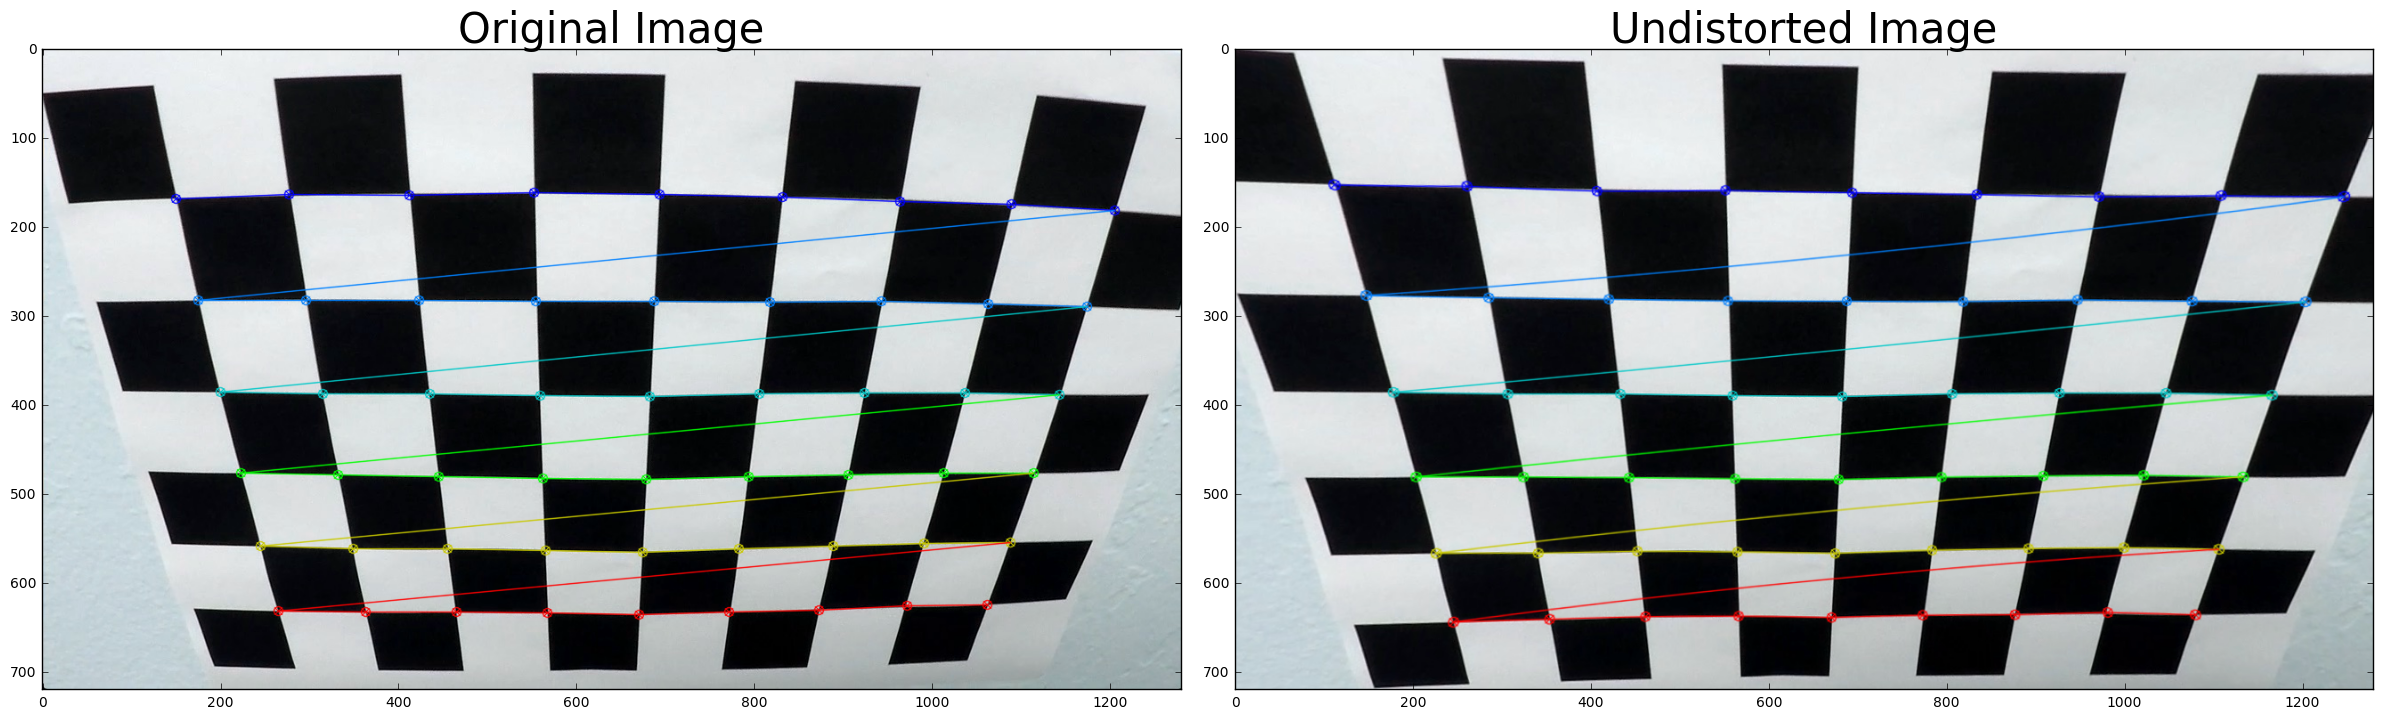

In [5]:
# Test the calibration on some image.
filenames = os.listdir(path)
img = cv2.imread(path + filenames[11])
ret, corners = cv2.findChessboardCorners(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), cshape, None)
img = cv2.drawChessboardCorners(img, cshape, corners, ret)
undst = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undst)
ax2.set_title('Undistorted Image', fontsize=30)

In [401]:
def gradient_magnitude(gray, sobel_kernel=3):
    """Compute mask based on gradient magnitude. Input image assumed
    to be two dimensional.
    """
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Norm and rescaling (c.f. different kernel sizes)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag) / 255.
    gradmag = (gradmag / scale_factor)
    return gradmag

def gradient_x(gray, sobel_kernel=3):
    """Compute mask based on horizontal gradient. Input image assumed
    to be two dimensional.
    """
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    gradmag = sobelx
    scale_factor = np.max(gradmag) / 255.
    gradmag = (gradmag / scale_factor)
    return gradmag

def mask_local_crossing_x(gray, threshold=20, dilate_kernel=(2, 6)):
    # Increasing mask.
    mask_neg = (gray < -threshold).astype(np.float32)
    mask_pos = (gray > threshold).astype(np.float32)
    
    iterations=4
    mid=dilate_kernel[1] // 2
    # Dilate mask to the left.
    kernel = np.ones(dilate_kernel, np.uint8)
    kernel[:, 0:mid] = 0
    dmask_neg = cv2.dilate(mask_neg, kernel, iterations=iterations) > 0.
    # Dilate mask to the right.
    kernel = np.ones(dilate_kernel, np.uint8)
    kernel[:, mid:] = 0
    dmask_pos = cv2.dilate(mask_pos, kernel, iterations=iterations) > 0.
    dmask = (dmask_pos * dmask_neg).astype(np.uint8)
    return dmask
    

def mask_threshold(gray, threshold=(0, 255)):
    mask = np.zeros_like(gray)
    mask[(gray >= threshold[0]) & (gray <= threshold[1])] = 1
    return mask


def color_threshold(gray, threshold=(0, 255)):
    mask = np.zeros_like(gray)
    mask[(gray >= threshold[0]) & (gray <= threshold[1])] = 1
    return mask

In [402]:
# Test images.
path = 'test_images/'
filenames = os.listdir(path)
print(filenames)

['signs_vehicles_xygrad.jpg', 'test (1).jpg', 'test (10).jpg', 'test (11).jpg', 'test (12).jpg', 'test (13).jpg', 'test (14).jpg', 'test (15).jpg', 'test (16).jpg', 'test (17).jpg', 'test (18).jpg', 'test (19).jpg', 'test (2).jpg', 'test (3).jpg', 'test (4).jpg', 'test (5).jpg', 'test (6).jpg', 'test (7).jpg', 'test (8).jpg', 'test (9).jpg', 'test1.jpg', 'test2.jpg', 'test3.jpg', 'test4.jpg', 'test5.jpg', 'test6.jpg']


test_images/test2.jpg


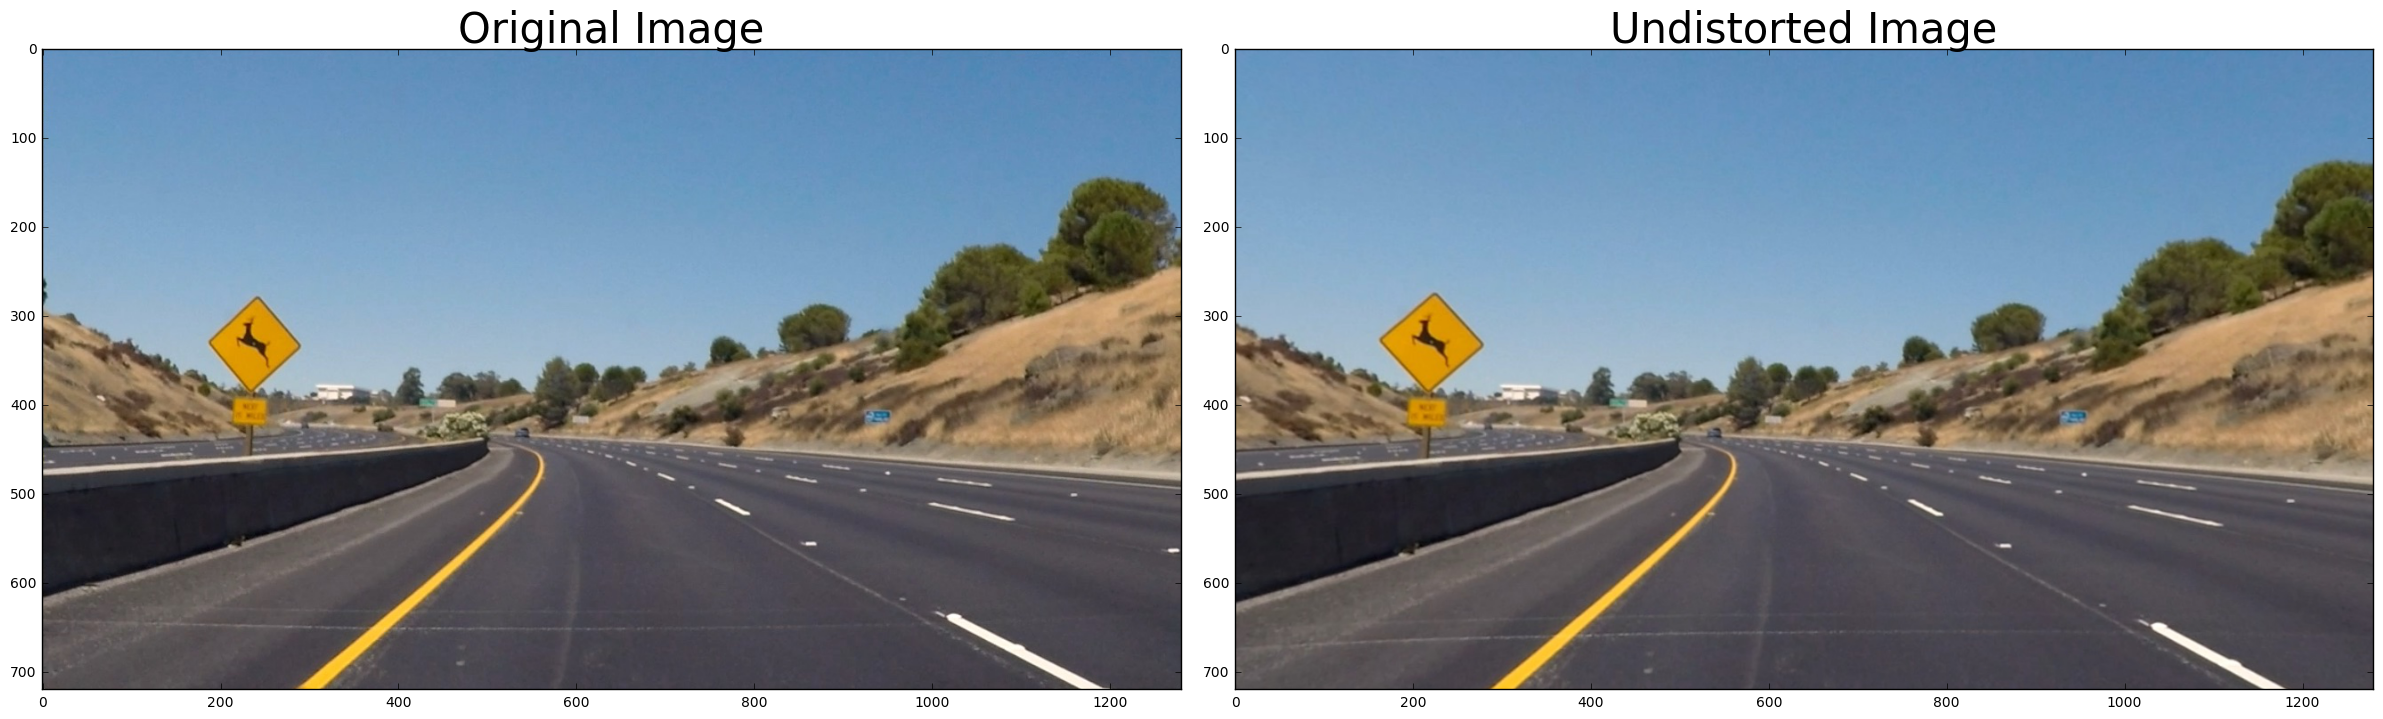

In [420]:
# Test on some image...
filename = path + os.listdir(path)[21]
print(filename)
img = mpimg.imread(filename)
undst = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undst)
ax2.set_title('Undistorted Image', fontsize=30)
plt.show()

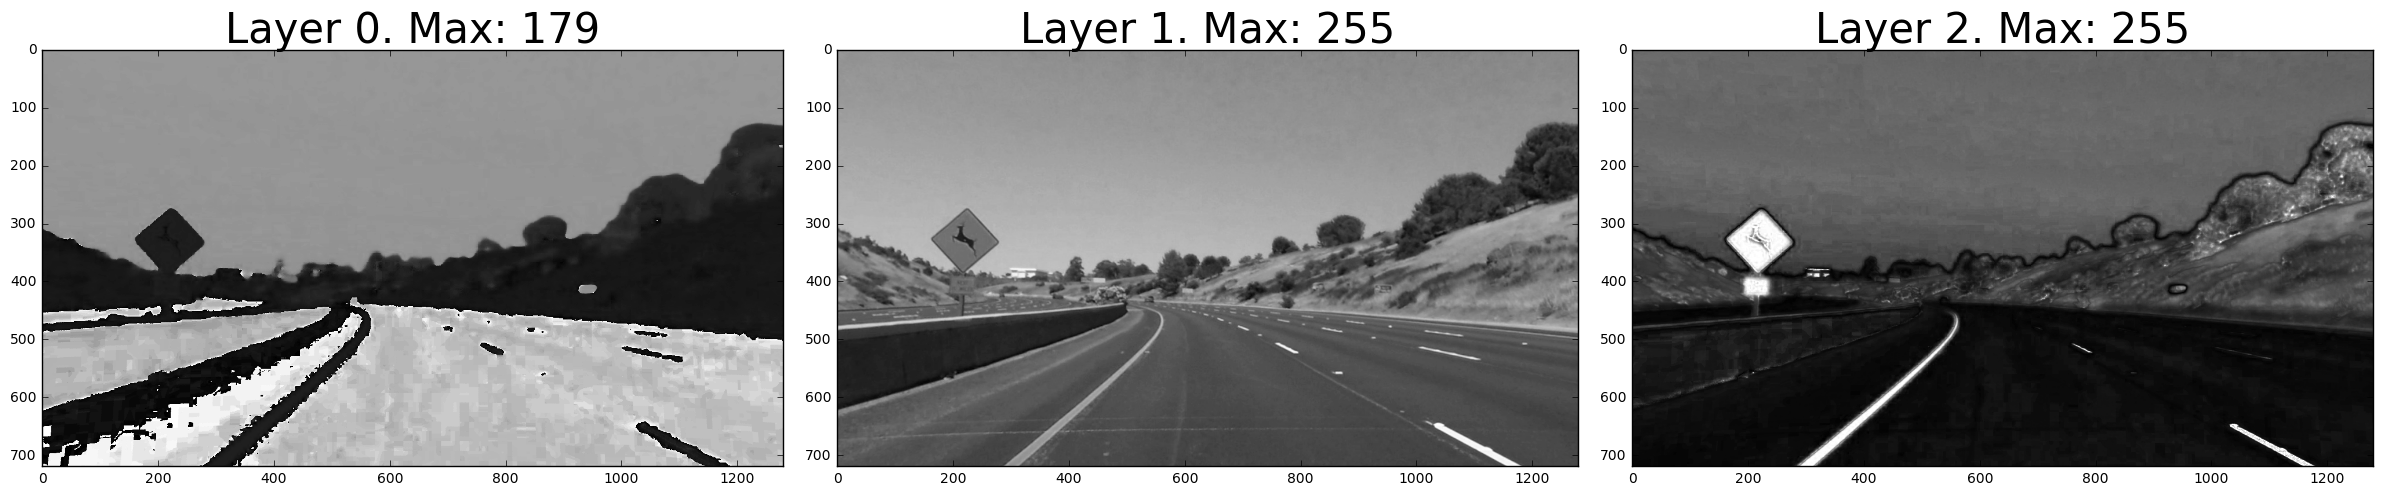

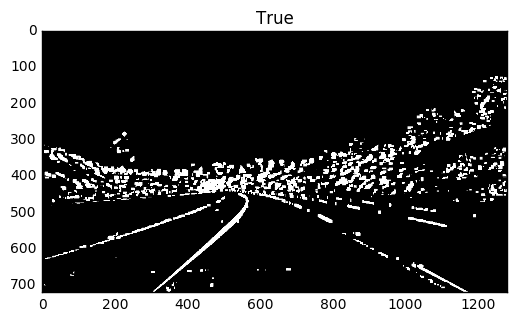

In [421]:
ungray = cv2.cvtColor(undst, cv2.COLOR_RGB2GRAY)
unhsl = cv2.cvtColor(undst, cv2.COLOR_RGB2HLS)

f, axes = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
for i in range(3):
    axes[i].imshow(unhsl[:, :, i], cmap='gray')
    axes[i].set_title('Layer %i. Max: %i' % (i, np.max(hsl[:, :, i])), fontsize=30)
plt.show()

dx = cv2.Sobel(ungray, cv2.CV_64F, 1, 0, ksize=5)
scale_factor = np.max(dx) / 255 
dx = (dx / scale_factor)
limit = 20
mask1 = dx < -limit
mask2 = dx > limit

kernel = np.ones((2,6), np.uint8)
kernel[:, 0:3] = 0
dmask1 = cv2.dilate(mask1.astype(np.float32), kernel, iterations=3) > 0.
kernel = np.ones((2,6), np.uint8)
kernel[:, 3:] = 0
dmask2 = cv2.dilate(mask2.astype(np.float32), kernel, iterations=3) > 0.
dmask = (dmask1.astype(np.float32) - dmask2.astype(np.float32)) < 1.
dmask = dmask1 * dmask2

dmask0 = mask_local_crossing_x(dx)

color_binary = np.dstack(( dmask, dmask1, dmask2))
plt.imshow(dmask0, cmap='gray')
# plt.imshow(color_binary)
plt.title(np.max(dmask))
plt.show()


In [422]:
sobel_dx = gradient_x(ungray, sobel_kernel=5)
sobel_mag = gradient_magnitude(ungray, sobel_kernel=5)

s_sobel_dx = gradient_x(unhsl[:, :, 2], sobel_kernel=5)
s_sobel_mag = gradient_magnitude(unhsl[:, :, 2], sobel_kernel=5)

masks = []
masks.append(mask_threshold(sobel_mag, threshold=(50, 255)))
masks.append(mask_threshold(s_sobel_mag, threshold=(30, 255)))
# masks.append(color_threshold(unhsl[:, :, 2], threshold=(10, 255)))
# masks.append(color_threshold(unhsl[:, :, 2], threshold=(10, 255)))
masks.append(mask_local_crossing_x(sobel_dx, threshold=20))
masks.append(mask_local_crossing_x(s_sobel_dx, threshold=30))



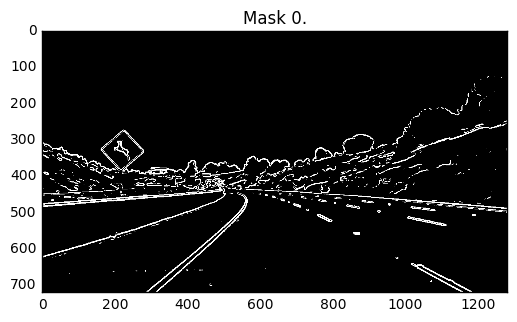

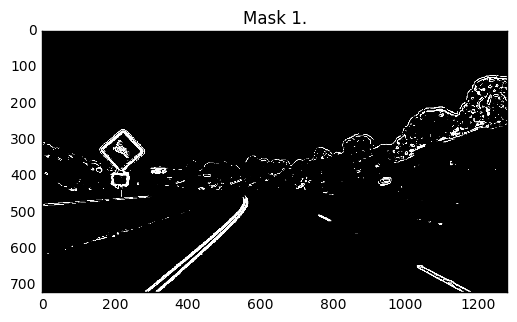

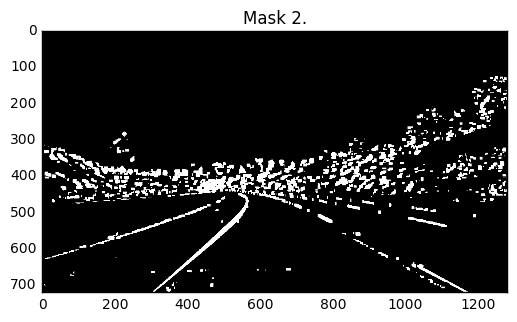

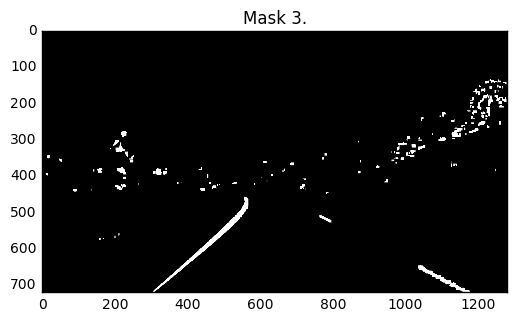

In [423]:
for i, m in enumerate(masks):
    plt.imshow(m, cmap='gray')
    plt.title('Mask %i.' % (i))
    plt.show()